In [1]:
%load_ext autoreload
%autoreload 2
import bnl

## Tests for checking metrics are working

In [3]:
def simple_hierarchy():
    # Level 0 - coarsest segmentation
    level0_itvls = [(0.0, 10.0), (10.0, 20.0)]
    level0_labels = ["A", "B"]

    # Level 1 - finer segmentation
    level1_itvls = [(0.0, 6.0), (6.0, 10.0), (10.0, 16.0), (16.0, 20.0)]
    level1_labels = ["A1", "A2", "B1", "B2"]

    # Level 2 - finest segmentation
    level2_itvls = [
        (0.0, 3),
        (3, 5.0),
        (5.0, 7.5),
        (7.5, 10.0),
        (10.0, 13),
        (13, 15.0),
        (15.0, 17.5),
        (17.5, 20.0),
    ]
    level2_labels = ["A1a", "A1b", "A2a", "A2b", "B1a", "B1b", "B2a", "B2b"]

    hier_itvls = [level0_itvls, level1_itvls, level2_itvls]
    hier_labels = [level0_labels, level1_labels, level2_labels]

    return bnl.H(hier_itvls, hier_labels)



In [4]:
h = simple_hierarchy()

(<Figure size 500x170 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

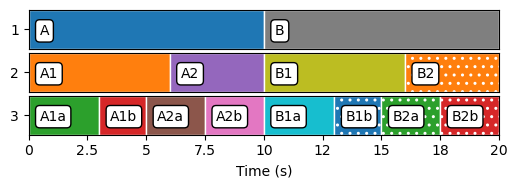

In [5]:
h.plot()

In [7]:
s1 = h.levels[1]
s2 = h.levels[2]
bnl.fmtr.entropy(s1.itvls, s1.labels)

1.3661588475692017

In [8]:
h1 = bnl.levels2H(h.levels[1:])
h2 = bnl.levels2H([h.levels[0]])

In [18]:
import mir_eval
c = bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)
d = mir_eval.hierarchy.lmeasure(
    h1.itvls,
    h1.labels,
    h2.itvls,
    h2.labels
)
c, d

((0.55, 0.63448057332204, 0.5892275874958476),
 (0.544941777533307, 0.6354240901584928, 0.5867149206128454))

In [19]:
import mir_eval
a = bnl.fmtr.pairwise(s1.itvls, s1.labels, s2.itvls, s2.labels)
b = mir_eval.segment.pairwise(
    s1.itvls, s1.labels, s2.itvls, s2.labels
)  # beta=1.0 is the default value

a, b

((0.8823529411764706, 0.4326923076923077, 0.5806451612903226),
 (0.8775510204081632, 0.4215686274509804, 0.5695364238410596))

In [20]:
import mir_eval
a = bnl.fmtr.vmeasure(s1.itvls, s1.labels, s2.itvls, s2.labels)
b = mir_eval.segment.vmeasure(
    s1.itvls, s1.labels, s2.itvls, s2.labels
)  # beta=1.0 is the default value

a, b

((0.5788736377909488, 0.8768423473948979, 0.697362568757996),
 (0.5788736377909488, 0.8768423473948981, 0.6973625687579961))

## Let's plot!

- Figure 1: how framesize affect the triplet metrics
- Figure 2: how continuous compares with 0.5: scatter plot


517-0
517-1


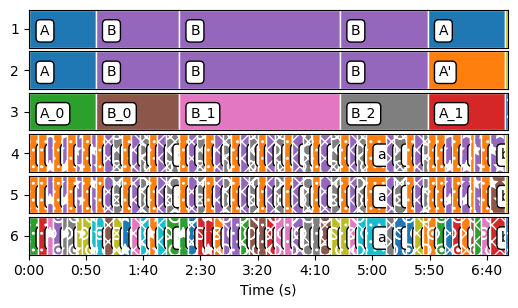

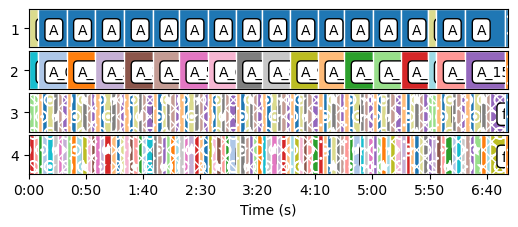

In [2]:
import random
tids = bnl.fio.salami_tids()
tid = random.choice(tids)
salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
while len(salami_hiers) < 2:
    tid = random.choice(tids)
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)

hiers = {'-'.join([str(tid), str(i)]): h for i, h in enumerate(salami_hiers)}

for tid, h in hiers.items():
    print(tid)
    h.expand(format='slm', always_include=False).plot();

## Comparing Mir_eval implementation and my implementation


### Ok. now I need to do this over all tracks that have 2 annotations and record all the times and results, for several configs


In [5]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import metrics
import os, pqdm
import xarray as xr, numpy as np
from pqdm.processes import pqdm
from glob import glob
from tqdm import tqdm

In [15]:
## Alright we just timed everything, now let's plot
from bnl import fio, mtr, prf
# collect all datas from single_anno
from glob import glob

fns = glob('./single_anno/*.nc')
# Load all the nc files and concatenate them into a single xarray dataset
import xarray as xr 
ds_all = [xr.open_dataset(fn) for fn in fns]
ds = xr.concat(ds_all, dim='tid')
my_df = ds.sel(version='my').to_dataframe()
me_df = ds.sel(version='mir_eval').to_dataframe()
my_df.describe()

In [81]:
import numpy as np
my_total_time = np.sum(my_df).values[0]
me_total_time = np.sum(me_df).values[0]
print(f"Total time for my version: {my_total_time} secs")
print(f"Total time for mir_eval version: {me_total_time /60} mins")

Total time for my version: 40.08199143409729 secs
Total time for mir_eval version: 83.27204002539317 mins


/Users/tomxi/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/tomxi/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [70]:
me_df.describe()

,__xarray_dataarray_variable__
count,475.000000
mean,10.518573
std,21.858224
min,0.010928
25%,3.189465
50%,5.436050
75%,9.688576
max,252.743326


In [89]:
my_times = ds.sel(version='my').sortby('__xarray_dataarray_variable__', ascending=False)
me_times = ds.sel(version='mir_eval').sortby('__xarray_dataarray_variable__', ascending=False)

In [101]:
# let's look at the 10 most time-consuming tracks in me

longest_me_times = me_times.sel(tid=me_times.tid[:10])

In [102]:
longest_me_times.sum()

<xarray.Dataset> Size: 40B
Dimensions:                        ()
Coordinates:
    version                        <U8 32B 'mir_eval'
Data variables:
    __xarray_dataarray_variable__  float64 8B 1.314e+03

In [103]:
# The longest 10 tracks alone took 2 hours in total to compute!

In [ ]:
# Get the duration of all reference annotations
dur_dict = {}
for tid in fio.salami_tids():
    refs = fio.salami_ref_hiers(tid)
    if len(refs) == 2:
        dur = list(refs.values())[0].T
        dur_dict[tid] = dur


In [26]:
# Save it to a file
import json
with open('salami_durations.json', 'w') as f:
    json.dump(dur_dict, f)
# Load the file
with open('salami_durations.json', 'r') as f:
    dur_dict = json.load(f)

In [27]:
with open('salami_durations.json', 'r') as f:
    dur_dict = json.load(f)

In [29]:
from glob import glob
from tqdm import tqdm
import os
import xarray as xr
## Time to collect
track_results_fpaths = glob('./new_faster_compare/*.nc')

das = []
for fp in tqdm(track_results_fpaths):
    tid = os.path.basename(fp).split('.')[0]
    # Load the data array and assign the tid as a coordinate
    da = xr.open_dataarray(fp)
    das.append(da)

# Concatenate all the data arrays along the 'tid' dimension
final_da = xr.concat(das, dim='tid')


100%|██████████| 883/883 [00:01<00:00, 789.34it/s]


In [30]:
#  Save the final data array to a NetCDF file
final_da.to_netcdf('./new_faster_compare.nc')

### Alright, I can load from saved data now. Now let's do scatter plot to see how they differ

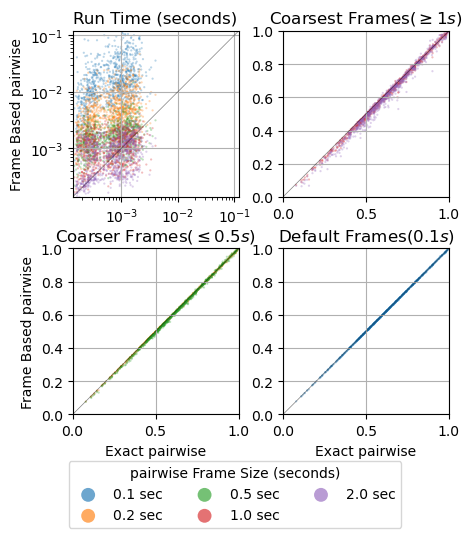

In [33]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from bnl import viz

# Load the data array from the NetCDF file
# results = xr.open_dataarray('./compare_implementation.nc')
# results = xr.open_dataarray('./new_compare.nc')
results = xr.open_dataarray('./new_faster_compare.nc')
metric='pairwise'

fig, axes = plt.subplots(2, 2, figsize=(4.5,4.5), constrained_layout=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
else:
    axes = axes.ravel()

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='run_time', metric=metric), ax=axes[0], log_scale=True
)
axes[0].set_title('Run Time (seconds)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[1,2], ax=axes[1], color_start_idx=3
)
axes[1].set_title('Coarsest Frames($\geq 1s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.2, 0.5], ax=axes[2], color_start_idx=1
)
axes[2].set_title('Coarser Frames($\leq 0.5s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.1], ax=axes[3], color_start_idx=0
)
axes[3].set_title('Default Frames($0.1s$)')

# Set the title for each subplot
# Create the legend for the middle subplot into a row of handle, and plot the thin bar under the how figure
axes[0].set_ylabel(f'Frame Based {metric}')
axes[2].set_ylabel(f'Frame Based {metric}')
axes[2].set_xlabel(f'Exact {metric}')
axes[3].set_xlabel(f'Exact {metric}')

# Plot the legend with bigger handles
handles, labels = axes[0].get_legend_handles_labels()
for h in handles:
    h.set_sizes([100])  # Adjust the size as needed
    h.set_alpha(0.65)  # Set transparency for better visibility
leg = fig.legend(handles, labels, 
           loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5,-0.17)
          )
leg.set_title(f'{metric} Frame Size (seconds)')

# Set all the handles in the plot back to the smaller size.
for ax in axes:
    handles, _ = ax.get_legend_handles_labels()
    for h in handles:
        # Set it back!
        h.set_sizes([2.5])  # Adjust the size as needed
        h.set_alpha(0.3)  # Set transparency for better visibility
    
# Show the plot
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
# fig.savefig('../../../text/hier_metric/figs/compare_implementation.pdf', transparent=True, bbox_inches='tight')
# fig.savefig(f'./compare_implementation_{metric}.pdf', transparent=True, bbox_inches='tight')


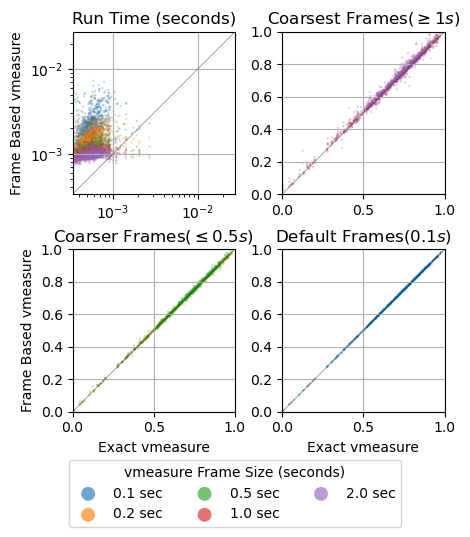

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from bnl import viz

# Load the data array from the NetCDF file
# results = xr.open_dataarray('./compare_implementation.nc')
# results = xr.open_dataarray('./new_compare.nc')
results = xr.open_dataarray('./new_faster_compare.nc')

fig, axes = plt.subplots(2, 2, figsize=(4.5,4.5), constrained_layout=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
else:
    axes = axes.ravel()

metric='vmeasure'

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='run_time', metric=metric), ax=axes[0], log_scale=True
)
axes[0].set_title('Run Time (seconds)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[1,2], ax=axes[1], color_start_idx=3
)
axes[1].set_title('Coarsest Frames($\geq 1s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.2, 0.5], ax=axes[2], color_start_idx=1
)
axes[2].set_title('Coarser Frames($\leq 0.5s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='f', metric=metric), frame_sizes=[0.1], ax=axes[3], color_start_idx=0
)
axes[3].set_title('Default Frames($0.1s$)')

# Set the title for each subplot
# Create the legend for the middle subplot into a row of handle, and plot the thin bar under the how figure
axes[0].set_ylabel(f'Frame Based {metric}')
axes[2].set_ylabel(f'Frame Based {metric}')
axes[2].set_xlabel(f'Exact {metric}')
axes[3].set_xlabel(f'Exact {metric}')

# Plot the legend with bigger handles
handles, labels = axes[0].get_legend_handles_labels()
for h in handles:
    h.set_sizes([100])  # Adjust the size as needed
    h.set_alpha(0.65)  # Set transparency for better visibility
leg = fig.legend(handles, labels, 
           loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5,-0.17)
          )
leg.set_title(f'{metric} Frame Size (seconds)')

# Set all the handles in the plot back to the smaller size.
for ax in axes:
    handles, _ = ax.get_legend_handles_labels()
    for h in handles:
        # Set it back!
        h.set_sizes([2.5])  # Adjust the size as needed
        h.set_alpha(0.3)  # Set transparency for better visibility
    
# Show the plot
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
# fig.savefig('../../../text/hier_metric/figs/compare_implementation.pdf', transparent=True, bbox_inches='tight')
fig.savefig(f'./compare_implementation_{metric}.pdf', transparent=True, bbox_inches='tight')


### New plots
Run speed on salami anno against each other

In [ ]:
import numpy as np
import xarray as xr
import seaborn as sns
import json

import matplotlib.pyplot as plt

def plot_runtime_vs_duration(results_path, metric, ax, dur_dict_path='salami_durations.json', q_Factor=10):
    """
    Plots the runtime vs duration for different frame sizes for a given metric.

    Args:
        results_path (str): Path to the xarray data array containing the results.
        metric (str): The metric to plot.
        ax (matplotlib.axes._axes.Axes): The axes to plot on.
        dur_dict_path (str): Path to the JSON file containing the duration dictionary.
    """
    results = xr.open_dataarray(results_path)
    with open(dur_dict_path, 'r') as f:
        dur_dict = json.load(f)

    def get_runtime_vs_duration(results, dur_dict, frame_size, metric):
        x = []
        y = []
        for tid in results['tid'].values:
            tid = str(tid)
            duration = np.round(dur_dict[tid] / q_Factor) * q_Factor
            runtime = results.sel(tid=tid, output='run_time', frame_size=frame_size, metric=metric).item()
            x.append(duration)
            y.append(runtime)
        return x, y
    

    frame_sizes = [0.1, 0.2, 0.5, 1, 2, 0]

    for frame_size in frame_sizes:
        x, y = get_runtime_vs_duration(results, dur_dict, frame_size, metric)
        sns.lineplot(x=x, y=y, label=f'{frame_size} sec', ax=ax, errorbar=('ci', 99.9), legend=False)

    ax.set_title(f'Runtime vs Duration for Different Frame Sizes ({metric})')
    ax.set_xlabel('Duration (seconds)')
    ax.set_yscale('log')
    # ax.grid(True, which="both", ls="--", alpha=0.5)



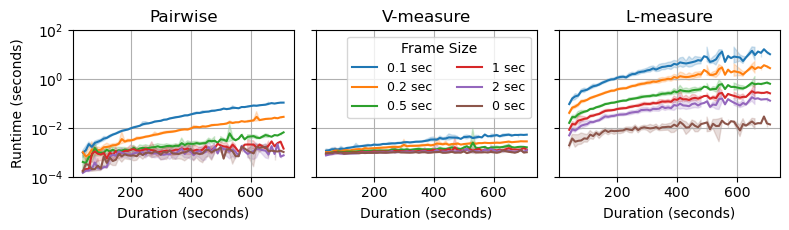

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(8, 2.4), sharex=True, sharey=True)  # Adjust figsize as needed

metrics = ['pairwise', 'vmeasure', 'lmeasure']

for i, metric in enumerate(metrics):
    plot_runtime_vs_duration('./new_faster_compare.nc', metric, ax=axes[i])
    axes[i].set_title(f'{metric}')
    axes[i].grid(True)
    # axes[i].sharey(axes[0])  # Share y-axis with the first subplot
    axes[i].set_ylim(1e-4, 100)

axes[0].set_ylabel('Runtime (seconds)')
axes[1].set_xlabel('Duration (seconds)')
axes[1].legend(title='Frame Size', fontsize=9, ncol=2)
axes[0].set_title('Pairwise')
axes[1].set_title('V-measure')
axes[2].set_title('L-measure')

plt.tight_layout()  # Adjust layout to prevent overlap
fig.savefig('./runtime_vs_duration.pdf', transparent=True, bbox_inches='tight')



### Next plot:
accuracy


In [7]:
# Let's get the accurcay of our results by plotting the residual
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
results = xr.open_dataarray('./new_faster_compare.nc')
metrics_list = ['pairwise', 'vmeasure', 'lmeasure']


In [9]:

my_results = results.sel(output='run_time', metric=metrics_list, frame_size=0)
all_results = results.sel(output='run_time', metric=metrics_list)
all_results.name='run_time'
my_results.name='my_run_time'

In [10]:
run_time_df = all_results.to_dataframe().reset_index().drop(columns=['output', 'metric'])

In [11]:
# add duration to the dataframe for each tid
import json
dur_dict = json.load(open('salami_durations.json'))
run_time_df['duration'] = run_time_df['tid'].map(dur_dict)
run_time_df['duration'] = np.round((run_time_df['duration']/10)) * 10 + 1

In [26]:
import pandas as pd

def plot_runtime(ax, metric='pairwise', **kwargs):
    results = xr.open_dataarray('./new_faster_compare.nc')
    all_results = results.sel(output='run_time', metric=metric)
    all_results.name='run_time'
    run_time_df = all_results.to_dataframe().reset_index().drop(columns=['output', 'metric'])
    # Custom palette: 5 shades from black to gray, plus a bright red
    # add 0, 0 to DF so it all connects down
    run_time_df = pd.concat(
        [run_time_df, pd.DataFrame([{'tid': 0, 'run_time': 0, 'duration': 0}])],
        ignore_index=True
    )
    custom_palette = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC']
    cp = ['#FF0000'] + custom_palette
    dur_dict = json.load(open('salami_durations.json'))
    run_time_df['duration'] = run_time_df['tid'].map(dur_dict)
    run_time_df['duration'] = np.round((run_time_df['duration']/15)) * 15 + 0.1
    
    # Plot run_time_df using seaborn lineplot on the provided axes (ax)
    sns.lineplot(data=run_time_df, x='duration', y='run_time', hue='frame_size',
                 alpha=0.5, palette=cp, ax=ax, **kwargs)

    ax.set_yscale('log')
    return ax


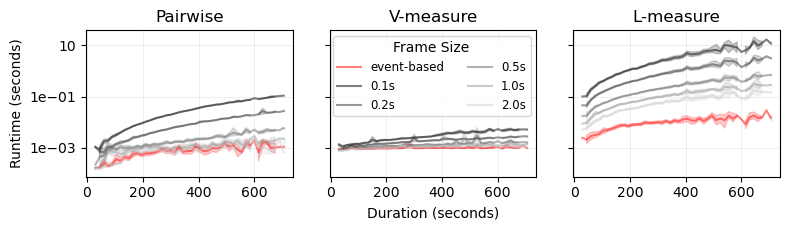

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.4), sharey=True, sharex=True)

plot_runtime(axes[1], 'vmeasure')

# axes[1].legend(title='Frame Size', fontsize=9, ncol=2)
axes[0].set_title('Pairwise')
axes[1].set_title('V-measure')
axes[2].set_title('L-measure')
plot_runtime(axes[2], 'lmeasure', legend=False)
plot_runtime(axes[0], 'pairwise', legend=False)
axes[0].set_ylabel('Runtime (seconds)')
axes[1].set_xlabel('Duration (seconds)')
axes[2].set_xlabel('')
axes[0].set_xlabel('')

# Add clean gridlines and customize y-ticks for all subplots
for ax in axes:
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)  # Put grid behind the data
    
    # Customize y-ticks to show fewer, cleaner values
    from matplotlib.ticker import LogLocator, LogFormatter
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=5))
    ax.yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))

    # Make minor gridlines lighter
    ax.grid(True)
# Adjust legend labels: replace '0.0' with 'event-based'
handles, labels = axes[1].get_legend_handles_labels()
new_labels = ['event-based' if label == '0.0' else label + "s" for label in labels]
axes[1].legend(handles, new_labels, title='Frame Size', fontsize=8.5, ncol=2)
# Save the plot with clean styling
fig.tight_layout()
plt.savefig('./runtime_vs_duration_br2.pdf', transparent=True, bbox_inches='tight')

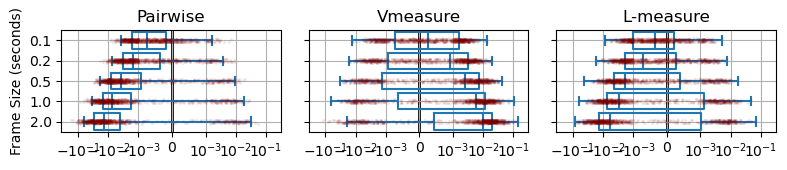

In [72]:
results = xr.open_dataarray('./new_faster_compare.nc')
metrics_list = ['pairwise', 'vmeasure', 'lmeasure']

fig, axes = plt.subplots(1, 3, figsize=(8, 1.8), sharey=True, sharex=True)

for ax, metric in zip(axes, metrics_list):
    my_results = results.sel(output='f', metric=metric, frame_size=0)
    all_results = results.sel(output='f', metric=metric).drop_sel(frame_size=0)
    residual = all_results - my_results
    residual.name = 'Residual'
    
    residual_df = residual.to_dataframe().reset_index().drop(columns=['output', 'metric'])
    
    
    sns.stripplot(data=residual_df, x='Residual', y='frame_size', color='maroon', alpha=0.1, jitter=0.1, size=2, ax=ax, orient='h', rasterized=True)
    sns.boxplot(data=residual_df, x='Residual', y='frame_size', orient='h', fill=False, fliersize=0, ax=ax)
    ax.axvline(0, zorder=-1, color='k', linewidth=2)
    ax.set_xscale('symlog', linthresh=0.001)
    ax.grid(True)
    ax.set_title(metric.capitalize())

axes[0].set(ylabel='Frame Size (seconds)', xlabel='')
axes[1].set(xlabel='')
axes[2].set(xlabel='', title='L-measure')
plt.tight_layout()
plt.savefig('./frame_size_metrics_comparison.pdf', bbox_inches='tight')



In [71]:
results.sel(output='run_time', metric='pairwise').plot(ax=axes[0, 0], color='black', linestyle='--', label='Run Time')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [4]:
# collect all results into a single data array
# and save it to a file
import os
from glob import glob
all_result_paths = glob('./depth_sweep/*.nc')

# Let's get the results from the depth sweep:
das = []
for fp in all_result_paths:
    # Load the data array and assign the tid as a coordinate
    tid = os.path.basename(fp).split('.')[0]
    da = xr.open_dataarray(fp)
    # make sure da.tid is a string
    # Append the data array to the list
    das.append(xr.open_dataarray(fp))
# Concatenate all the data arrays along the 'tid' dimension
final_da = xr.concat(das, dim='tid')
final_da['tid'] = final_da['tid'].astype(str)
final_da.to_netcdf('./depth_sweep_all.nc')



In [15]:
# load the data array
da = xr.open_dataarray('./depth_sweep_all.nc')

da


<xarray.DataArray (level: 12, tid: 884, output: 4, frame_size: 6)> Size: 2MB
[254592 values with dtype=float64]
Coordinates:
  * tid         (tid) object 7kB '429' '18' '538' '478' ... '6' '99' '628' '768'
  * level       (level) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * frame_size  (frame_size) float64 48B 0.0 0.1 0.2 0.5 1.0 2.0
  * output      (output) object 32B 'run_time' 'lp' 'lr' 'lf'

In [3]:
# load the data array
import xarray as xr
da = xr.open_dataarray('./depth_sweep.nc')

da


<xarray.DataArray (level: 12, tid: 1359, version: 2, output: 4)> Size: 1MB
[130464 values with dtype=float64]
Coordinates:
  * tid      (tid) object 11kB '429' '18' '538' '478' ... '6' '99' '628' '768'
  * level    (level) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * output   (output) object 32B 'run_time' 'lp' 'lr' 'lf'
  * version  (version) object 16B 'mir_eval' 'my'

### Next plot:
Figure out what how many times adobe did this evaluation


In [5]:
# Collect all results from scripts/depth_sweep/ into a single df ready for plotting, and save to feather
import os
from glob import glob
import pandas as pd
import xarray as xr

# Get all .nc files from depth_sweep directory
result_paths = glob('./depth_sweep/*.nc')

# Load and combine all results
das = []
for fp in result_paths:
    tid = os.path.basename(fp).split('.')[0]
    da = xr.open_dataarray(fp)
    das.append(da)

# Concatenate all data arrays along tid dimension
combined_da = xr.concat(das, dim='tid')
combined_da['tid'] = combined_da['tid'].astype(str)
combined_da

<xarray.DataArray (level: 12, tid: 884, output: 4, frame_size: 6)> Size: 2MB
array([[[[2.13599205e-03, 9.98188019e-01, 2.93366909e-01,
          7.46920109e-02, 3.74352932e-02, 1.96878910e-02],
         [5.30574851e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.97857195e-04, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.95566878e-04, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[4.56714630e-03, 1.92873716e+00, 5.73702335e-01,
          1.46749973e-01, 6.46622181e-02, 3.31840515e-02],
         [3.55673217e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.81820797e-05, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.36338024e-04, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.41684914e-03, 1.50690079e-01, 6.02319241e-02,
          2.39470005e-02, 1.34367943e-02, 8.58402252e-03],
...
         [3.84752419e-01, 3.83907994e-01, 3.83102630e-01,
          3.79481741e-01, 3.73037654e-01, 3.59519397e-01]],

        [[5.62281609e-02, 3.03754592e+00, 1.00196981e+00,
          2.97216892e-01, 1.16804838e-01, 5.98847866e-02],
         [4.79240145e-01, 4.79664184e-01, 4.80753152e-01,
          4.75549901e-01, 4.74560739e-01, 4.68746758e-01],
         [6.97664953e-01, 6.99088798e-01, 6.99837825e-01,
          6.93280709e-01, 6.89289937e-01, 6.83164448e-01],
         [5.68183541e-01, 5.68953569e-01, 5.69967494e-01,
          5.64135761e-01, 5.62116685e-01, 5.55999661e-01]],

        [[6.15921021e-02, 6.21875310e+00, 1.94943619e+00,
          5.00685930e-01, 2.10353136e-01, 1.00405931e-01],
         [1.84393228e-02, 1.81772737e-02, 1.74447251e-02,
          1.47690081e-02, 1.66896441e-02, 1.67624892e-02],
         [4.62636321e-01, 4.53795902e-01, 4.45759782e-01,
          4.28770870e-01, 4.25760051e-01, 4.30313872e-01],
         [3.54651106e-02, 3.49544115e-02, 3.35754801e-02,
          2.85544582e-02, 3.21201881e-02, 3.22680072e-02]]]])
Coordinates:
  * level       (level) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * frame_size  (frame_size) float64 48B 0.0 0.1 0.2 0.5 1.0 2.0
  * output      (output) object 32B 'run_time' 'lp' 'lr' 'lf'
  * tid         (tid) <U4 14kB '429' '18' '538' '478' ... '6' '99' '628' '768'

In [9]:

# Convert to DataFrame for plotting
df = combined_da.sel(output='run_time').to_dataframe(name='run_time').reset_index()

# Pivot to have separate columns for each output metric
df_pivot = df.pivot_table(
    index=['tid', 'level', 'frame_size'], 
    columns='output', 
    values='run_time'
).reset_index()

df_pivot['level'] += 1
df_pivot.columns.name = None
df_pivot.to_feather('./depth_sweep_runtime.feather')


In [8]:

df_pivot

,tid,level,frame_size,run_time
0,10,1,0.0,0.003101
1,10,1,0.1,2.027831
2,10,1,0.2,0.611674
3,10,1,0.5,0.146685
4,10,1,1.0,0.062012
...,...,...,...,...
63643,999,12,0.1,24.649294
63644,999,12,0.2,6.340426
63645,999,12,0.5,1.405876
63646,999,12,1.0,0.512563


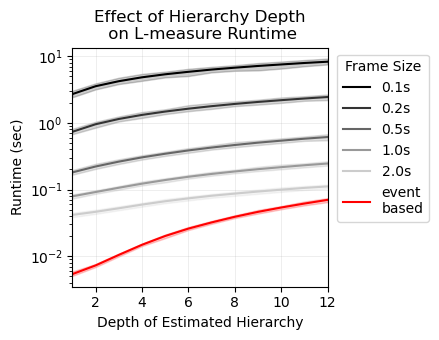

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_feather('./depth_sweep_runtime.feather')
plt.figure(figsize=(4.5, 3.5))

custom_palette = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC']
cp = ['#FF0000'] + custom_palette

ax = sns.lineplot(
    x='level', y='run_time', hue='frame_size',
    data=df, errorbar=('ci', 100),
    palette=cp
)



plt.yscale('log')
plt.xlabel('Depth of Estimated Hierarchy')
plt.ylabel('Runtime (sec)')
plt.title('Effect of Hierarchy Depth\n on L-measure Runtime')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xlim(1,12)

# Modify legend text to "mir_eval" and "ours"
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{lbl}s' if lbl != '0.0' else 'event\nbased' for lbl in labels]

# Roll the handles and labels to move the first item to the end
handles = handles[1:] + [handles[0]]
new_labels = new_labels[1:] + [new_labels[0]]

plt.legend(handles, new_labels, title='Frame Size', ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
# plt.savefig('./depth_sweep_runtime.pdf', bbox_inches='tight', transparent=True)




## Plot depth sweep run time

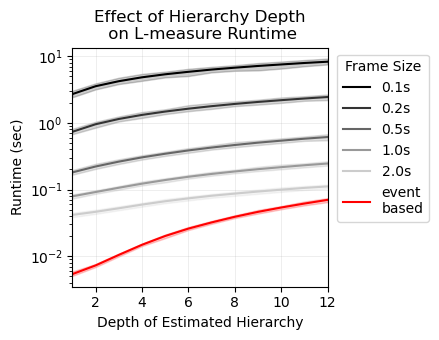

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_feather('./depth_sweep_runtime.feather')
plt.figure(figsize=(4.5, 3.5))

custom_palette = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC']
cp = ['#FF0000'] + custom_palette

ax = sns.lineplot(
    x='level', y='run_time', hue='frame_size',
    data=df, errorbar=('ci', 100),
    palette=cp
)



plt.yscale('log')
plt.xlabel('Depth of Estimated Hierarchy')
plt.ylabel('Runtime (sec)')
plt.title('Effect of Hierarchy Depth\n on L-measure Runtime')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xlim(1,12)

# Modify legend text to "mir_eval" and "ours"
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{lbl}s' if lbl != '0.0' else 'event\nbased' for lbl in labels]

# Roll the handles and labels to move the first item to the end
handles = handles[1:] + [handles[0]]
new_labels = new_labels[1:] + [new_labels[0]]

plt.legend(handles, new_labels, title='Frame Size', ncol=1, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
# plt.savefig('./depth_sweep_runtime.pdf', bbox_inches='tight', transparent=True)




### Plot Error per depth:

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

da = xr.open_dataarray('./depth_sweep_all.nc')
da


<xarray.DataArray (level: 12, tid: 884, output: 4, frame_size: 6)> Size: 2MB
[254592 values with dtype=float64]
Coordinates:
  * tid         (tid) object 7kB '429' '18' '538' '478' ... '6' '99' '628' '768'
  * level       (level) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * frame_size  (frame_size) float64 48B 0.0 0.1 0.2 0.5 1.0 2.0
  * output      (output) object 32B 'run_time' 'lp' 'lr' 'lf'

In [ ]:
# plot the residual between the event-based f measure (for frame_size=0) and the f measure for other frame sizes


In [ ]:

plt.figure(figsize=(4.5, 3.5))

custom_palette = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC']
cp = ['#FF0000'] + custom_palette

ax = sns.lineplot(
    x='level', y='f', hue='frame_size',
    data=l_measure_df, errorbar=('ci', 100),
    palette=cp
)

plt.xlabel('Depth of Estimated Hierarchy')
plt.ylabel('F1 Score')
plt.title('Effect of Hierarchy Depth\n on L-measure F1')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xlim(1,12)

In [17]:
da

<xarray.DataArray (level: 12, tid: 884, output: 4, frame_size: 6)> Size: 2MB
[254592 values with dtype=float64]
Coordinates:
  * tid         (tid) object 7kB '429' '18' '538' '478' ... '6' '99' '628' '768'
  * level       (level) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * frame_size  (frame_size) float64 48B 0.0 0.1 0.2 0.5 1.0 2.0
  * output      (output) object 32B 'run_time' 'lp' 'lr' 'lf'

### Next plot:
speed sweeping levels


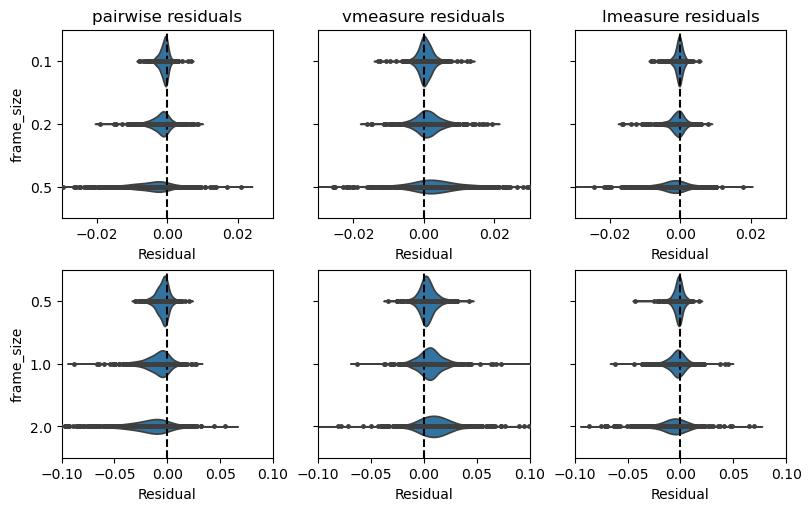

In [58]:
results = xr.open_dataarray('./new_faster_compare.nc')
def plot_residuals(results, metric, axes, legend=False):
    """
    Computes the residual between the frame‐based f measure (for frame_size=0) and the f measure for other frame sizes,
    and plots a KDE and a box plot on the provided axes.
    Args:
        results (xarray.DataArray): DataArray with coordinates 'tid', 'frame_size', 'output', and 'metric'.
        metric (str): The metric to plot (e.g., 'pairwise').
        axes (list): List of two matplotlib axes [ax_kde, ax_box] where the plots will be drawn.
    """
    # Get the frameless results (exact measure)
    my_results = results.sel(output='f', metric=metric, frame_size=0)
    # Get results with all frame sizes except 0 and compute residual with the exact measure
    all_results = results.sel(output='f', metric=metric).drop_sel(frame_size=0)
    residual = all_results - my_results
    residual.name = 'Residual'
    # Convert to a pandas DataFrame for plotting
    residual_df = residual.to_dataframe().reset_index().drop(columns=['output', 'metric'])
    # Slice the DataFrame to only include the first 3 frame sizes (assumes ascending order)
    first_three = sorted(residual_df['frame_size'].unique())[:3]
    last_three = sorted(residual_df['frame_size'].unique())[-3:]
    residual_df_fine = residual_df[residual_df['frame_size'].isin(first_three)]
    # Plot violin plot of residuals grouped by frame size on the first axis
    sns.violinplot(data=residual_df_fine, y='frame_size', x='Residual', ax=axes[0], orient='h', inner="point")
    axes[0].set_title(f'{metric} residuals')
    residual_df_coarse = residual_df[residual_df['frame_size'].isin(last_three)]
    sns.violinplot(data=residual_df_coarse, y='frame_size', x='Residual', ax=axes[1], orient='h', inner="point")
    # Calculate symmetrical limits for x-axis based on the maximum absolute residual value
    # x_abs_max = abs(residual_df_coarse['Residual']).max()
    lim_coarse = -0.04
    x_abs_max = abs(residual_df_fine['Residual']).max()
    lim_fine = x_abs_max + 0.001  # small margin
    # Set vertical line at 0 and symmetrical x-axis limits for both axes
    for ax, lim in zip(axes, [0.03, 0.1]):
        ax.axvline(0, color='black', linestyle='--')
        ax.set_xlim(-lim, lim)
fig, axes = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True, sharey='row')
plot_residuals(results, 'pairwise', axes[:, 0])
plot_residuals(results, 'vmeasure', axes[:, 1])
plot_residuals(results, 'lmeasure', axes[:, 2])

### Next plot:
2 flat level and their meets, then intersection


In [192]:
import bnl, mir_eval, random
hiers = bnl.fio.salami_ref_hiers(384)

In [194]:
hiers = []
while len(hiers) < 2:
    rand_id = random.choice(bnl.fio.salami_tids())
    hiers = list(bnl.fio.salami_ref_hiers(rand_id).values())

print(rand_id)


1071


In [ ]:
hiers = list(bnl.fio.salami_ref_hiers(464).values())

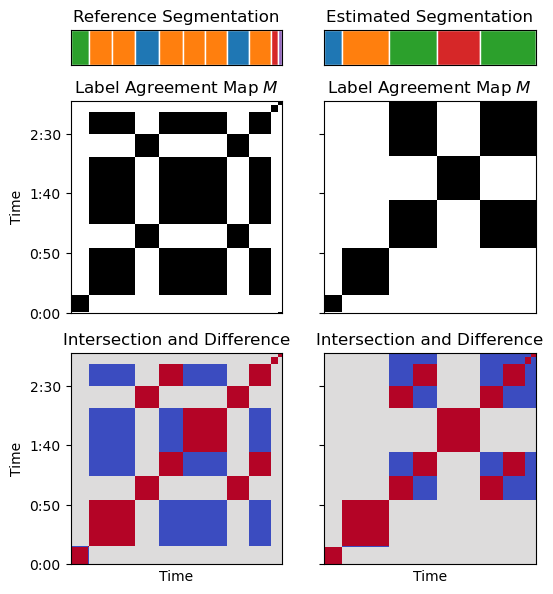

In [29]:
# hiers = []
# while len(hiers) < 2:
#     rand_id = random.choice(bnl.fio.salami_tids())
#     hiers = list(bnl.fio.salami_ref_hiers(rand_id).values())

import bnl, mir_eval
hiers = list(bnl.fio.salami_ref_hiers(464).values())


a = hiers[0].levels[0]
b = hiers[1].levels[0]

## Create a plot of 3 rows and 2 columns
fig, axes = plt.subplots(
    3, 2, figsize=(6, 7),
    gridspec_kw={'height_ratios': [0.8, 5, 5]}, sharey='row', sharex='col')

a.plot(ax=axes[0, 0], text=False)
b.plot(ax=axes[0, 1], text=False)
bnl.viz.sq(a.A(), a.beta, ax=axes[1, 0], cmap='gray_r')
bnl.viz.sq(b.A(), b.beta, ax=axes[1, 1], cmap='gray_r')

ci, al, bl = bnl.mtr.make_common_itvls([a.itvls], [a.labels], [b.itvls], [b.labels])
common_bs = mir_eval.util.intervals_to_boundaries(ci)
intersection = bnl.mtr._meet(al) * bnl.mtr._meet(bl)


false_positives = bnl.mtr._meet(bl) - intersection
false_negatives = bnl.mtr._meet(al) - intersection
# bnl.viz.sq(intersection, common_bs, ax=axes[2, 0])
bnl.viz.sq(-false_negatives.astype(int) + intersection.astype(int), common_bs, ax=axes[2, 0])
bnl.viz.sq(-false_positives.astype(int) + intersection.astype(int), common_bs, ax=axes[2, 1])

axes[0, 0].set(title='Reference Segmentation', xticks=[], xlabel='')
axes[0, 1].set(title='Estimated Segmentation', xticks=[], xlabel='')
axes[1, 0].set(title='Label Agreement Map $M$', xticks=[], xlabel='')
axes[1, 1].set(title='Label Agreement Map $M$', xticks=[], xlabel='', ylabel='')
axes[2, 0].set(title='Intersection and Difference')
axes[2, 1].set(title='Intersection and Difference', ylabel='')


fig.savefig('./explain_pfc.pdf', bbox_inches='tight', transparent=True)


## Let's do frame size sensitivity

In [ ]:
# Get a list of frame size, and plot their v-measure, pfc, and l-measure.
import numpy as np
import mir_eval, bnl
import pandas as pd
tid = '776'
salami_hiers = bnl.fio.salami_ref_hiers(tid='776')
adobe_hier = bnl.fio.adobe_hiers(tid='776')
test_fs = np.arange(0.03, 2.01, 0.02)


h1, h2 = salami_hiers
h1, adobe_hier = bnl.mtr.align_hier(h1, adobe_hier)


In [6]:
bnl.fmtr.lmeasure(adobe_hier.itvls, adobe_hier.labels, h1.itvls, h1.labels frame_size=fs)

(0.4758339360180916, 0.37821424882353394, 0.4214450141573712)

In [ ]:
df = pd.DataFrame(results, columns=['frame_size', 'vmeasure', 'pairwise', 'lmeasure'])
df.to_csv(f'./fs_sensitivity.csv', index=False)

In [10]:
# Doing on est and anno
results = []
for fs in test_fs:
    print(fs)
    # compute the metrics and save result
    _, _, v = mir_eval.segment.vmeasure(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1], frame_size=fs)
    _, _, p = mir_eval.segment.pairwise(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1], frame_size=fs)
    _, _, l = mir_eval.hierarchy.lmeasure(h1.itvls, h1.labels, adobe_hier.itvls, adobe_hier.labels, frame_size=fs)
    results.append([fs, v, p, l])

results = np.array(results)
df = pd.DataFrame(results, columns=['frame_size', 'vmeasure', 'pairwise', 'lmeasure'])
df.to_csv(f'./fs_sensitivity_adobe_776.csv', index=False)
results = results.T

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004
0.32
0.34
0.36000000000000004
0.38
0.4
0.42000000000000004
0.44
0.46
0.48000000000000004
0.5
0.52
0.54
0.56
0.5800000000000001
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.7200000000000001
0.74
0.76
0.78
0.8
0.8200000000000001
0.8400000000000001
0.86
0.88
0.9
0.92
0.9400000000000001
0.9600000000000001
0.98
1.0
1.02
1.04
1.06
1.08
1.1
1.12
1.1400000000000001
1.1600000000000001
1.18
1.2
1.22
1.24
1.26
1.28
1.3
1.32
1.34
1.36
1.3800000000000001
1.4000000000000001
1.4200000000000002
1.44
1.46
1.48
1.5
1.52
1.54
1.56
1.58
1.6
1.62
1.6400000000000001
1.6600000000000001
1.6800000000000002
1.7
1.72
1.74
1.76
1.78
1.8
1.82
1.84
1.86
1.8800000000000001
1.9000000000000001
1.9200000000000002
1.94
1.96
1.98
2.0


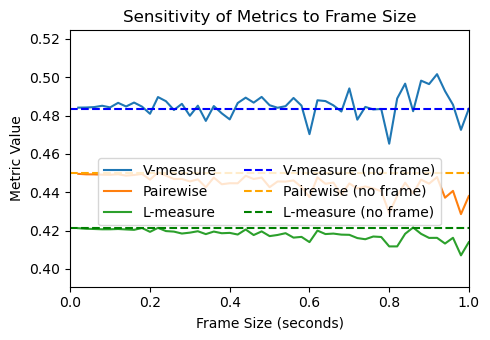

In [16]:
# Get the frameless results too
_, _, my_v = bnl.fmtr.vmeasure(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1])
_, _, my_p = bnl.fmtr.pairwise(h1.itvls[-1], h1.labels[-1], adobe_hier.itvls[-1], adobe_hier.labels[-1])
_, _, my_l = bnl.fmtr.lmeasure(h1.itvls, h1.labels, adobe_hier.itvls, adobe_hier.labels)

import matplotlib.pyplot as plt
# results = results.T
plt.figure(figsize=(5, 3.5))
plt.plot(results[0], results[1], label='V-measure')
plt.plot(results[0], results[2], label='Pairewise')
plt.plot(results[0], results[3], label='L-measure')

# plot the frameless results as hlines from 0 to 1
plt.axhline(my_v, color='blue', linestyle='--', label='V-measure (no frame)')
plt.axhline(my_p, color='orange', linestyle='--', label='Pairewise (no frame)')
plt.axhline(my_l, color='green', linestyle='--', label='L-measure (no frame)')
plt.xlabel('Frame Size (seconds)')
plt.ylabel('Metric Value')
plt.title('Sensitivity of Metrics to Frame Size')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.37))
plt.xlim(0,1)
# plt.ylim(0.455, 0.565)
plt.tight_layout()
plt.savefig(f'./fs_sensitivity_adobe.pdf', transparent=True, bbox_inches='tight')

In [ ]:
# Doing on two annotations
results = []
for fs in test_fs:
    # compute the metrics and save result
    _, _, v = mir_eval.segment.vmeasure(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1], frame_size=fs)
    _, _, p = mir_eval.segment.pairwise(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1], frame_size=fs)
    _, _, l = mir_eval.hierarchy.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels, frame_size=fs)
    results.append([fs, v, p, l])

results = np.array(results).T

In [45]:
# Save the result!
import pandas as pd
# results is a (4, 100) array, where rows are frame_size, vmeasure, pairwise, lmeasure
# We need to transpose it to get (100, 4) for the DataFrame
df = pd.DataFrame(results.T, columns=['frame_size', 'vmeasure', 'pairwise', 'lmeasure'])
df.to_csv(f'./fs_sensitivity.csv', index=False)

In [17]:
o = pd.read_csv(f'./fs_sensitivity.csv')
o

,frame_size,vmeasure,pairwise,lmeasure
0,0.02,0.537716,0.527019,0.467646
1,0.04,0.538196,0.527106,0.467727
2,0.06,0.537947,0.526762,0.466787
3,0.08,0.539330,0.527297,0.467814
4,0.10,0.533888,0.525532,0.467088
...,...,...,...,...
95,1.92,0.537807,0.515266,0.456873
96,1.94,0.563510,0.517994,0.458106
97,1.96,0.568477,0.526316,0.470278
98,1.98,0.567015,0.525930,0.464258


In [20]:
# Get the frameless results too
_, _, my_v = bnl.fmtr.vmeasure(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1])
_, _, my_p = bnl.fmtr.pairwise(h1.itvls[1], h1.labels[1], h2.itvls[1], h2.labels[1])
_, _, my_l = bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)

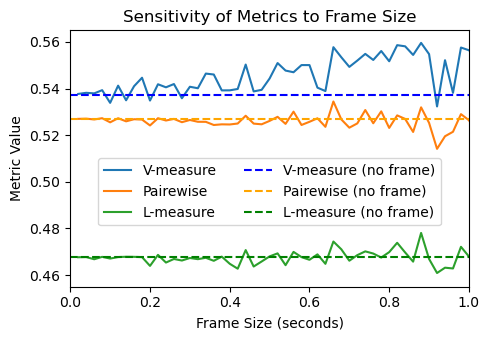

In [25]:
import matplotlib.pyplot as plt
results = o.to_numpy().T
plt.figure(figsize=(5, 3.5))
plt.plot(results[0], results[1], label='V-measure')
plt.plot(results[0], results[2], label='Pairewise')
plt.plot(results[0], results[3], label='L-measure')

# plot the frameless results as hlines from 0 to 1
plt.axhline(my_v, color='blue', linestyle='--', label='V-measure (no frame)')
plt.axhline(my_p, color='orange', linestyle='--', label='Pairewise (no frame)')
plt.axhline(my_l, color='green', linestyle='--', label='L-measure (no frame)')
plt.xlabel('Frame Size (seconds)')
plt.ylabel('Metric Value')
plt.title('Sensitivity of Metrics to Frame Size')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.37))
plt.xlim(0,1)
plt.ylim(0.455, 0.565)
plt.tight_layout()
plt.savefig(f'./fs_sensitivity_anno.pdf', transparent=True, bbox_inches='tight')

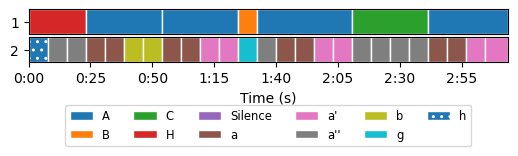

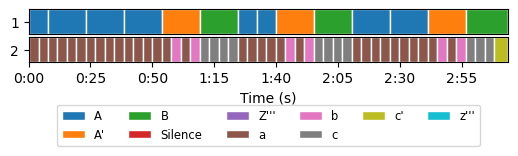

In [50]:
fig, axs = h1.plot(text=False, legend=6, legend_offset=1.5)
fig.savefig(f'./h1.pdf', transparent=True, bbox_inches='tight')
fig, axs = h2.plot(text=False, legend=6, legend_offset=1.5)
fig.savefig(f'./h2.pdf', transparent=True, bbox_inches='tight')

## What's up with the rho being zero in some segment business? Is that even possible?

Let's look at the code where this can be detected

In [2]:
tids = bnl.fio.salami_tids()


for tid in tids:
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
    if len(salami_hiers) < 2:
        continue
    h1, h2 = salami_hiers

    # try l-measure to see if the run time error surfaces
    try:
        _, _, l = bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)
    except Exception as e:
        print(f"Error for tid {tid}: {e}")
        continue

Error for tid 341: There are segments that are not meeting any other segments, please check your input.


In [1]:
import bnl
h1, h2 = bnl.fio.salami_ref_hiers(tid='341')

In [2]:
bnl.fmtr.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)

(0.0, 0.0, 0.0)

In [3]:
import mir_eval
mir_eval.hierarchy.lmeasure(h1.itvls, h1.labels, h2.itvls, h2.labels)

(0.0, 0.0, 0.0)

(<Figure size 500x130 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

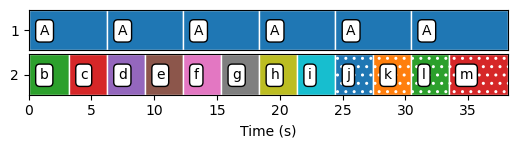

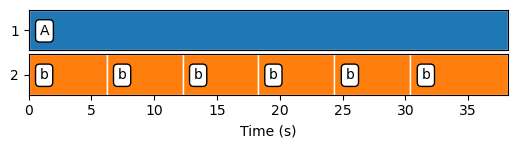

In [5]:
h1.plot();
h2.plot()

## Hierarchical Depth!

Let's get a track from adobe and compare

In [78]:
import bnl, random
from bnl import viz, fio
tids = fio.salami_tids()
random_tid = random.choice(tids)
salami_annos = fio.salami_ref_hiers(tid=random_tid)
salami_adobe = fio.adobe_hiers(tid=random_tid)

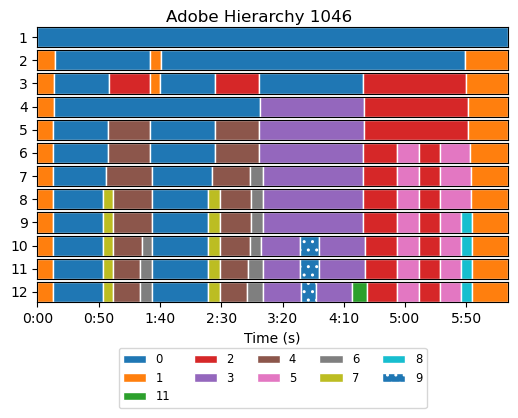

In [79]:
fig, axs = salami_adobe.plot(legend=5, text=False, legend_offset=2, figsize=(5,4.));
fig.suptitle(f'Adobe Hierarchy {random_tid}');

In [97]:
from tqdm import tqdm
import time
import os
import xarray as xr
import numpy as np
import mir_eval
import bnl


def time_depth_sweep(tid, frame_size=0.2, cache_dir='./depth_sweep', retime=False):

    # Check if already timed
    os.makedirs(cache_dir, exist_ok=True)
    output_filepath = os.path.join(cache_dir, f'{tid}.nc')
    if os.path.exists(output_filepath) and not retime:
        print(f"Already timed {tid}.")
        return xr.load_dataarray(output_filepath)

    adobe_hier = bnl.fio.adobe_hiers(tid=str(tid))
    salami_hier = bnl.fio.salami_ref_hiers(tid=str(tid))[0]
    ref, est = bnl.mtr.align_hier(salami_hier, adobe_hier)
     # Save the results to xarray
    result_da = xr.DataArray(
        dims=['level', 'tid', 'version', 'output'],
        coords={'level': range(est.d), 'tid': [tid], 'version': ['mir_eval', 'my'], 'output': ['run_time', 'lp', 'lr', 'lf']},
    )

    for d in range(est.d):
        start_time = time.time()
        mylp, mylr, mylm = bnl.fmtr.lmeasure(ref.itvls, ref.labels, est.itvls[:d+1], est.labels[:d+1])
        my_run_time = time.time() - start_time
        result_da.loc[dict(level=d, tid=tid, version='my')] = [my_run_time, mylp, mylr, mylm]
        
        start_time = time.time()
        melp, melr, melm = mir_eval.hierarchy.lmeasure(ref.itvls, ref.labels, est.itvls[:d+1], est.labels[:d+1], frame_size=frame_size)
        me_run_time = time.time() - start_time
        result_da.loc[dict(level=d, tid=tid, version='mir_eval')] = [me_run_time, melp, melr, melm]

    # Save the results to a NetCDF file
    result_da.to_netcdf(output_filepath)
    print(f"Timed {tid} and saved to {output_filepath}.")
    return result_da

In [98]:
time_depth_sweep(776)

Timed 776 and saved to ./depth_sweep/776.nc.


<xarray.DataArray (level: 12, tid: 1, version: 2, output: 4)> Size: 768B
array([[[[3.42381239e-01, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [1.50418282e-03, 1.93624069e-01, 1.60252169e-04,
          3.20239292e-04]]],


       [[[4.00398731e-01, 5.95915678e-01, 9.44113073e-02,
          1.62998635e-01],
         [1.53207779e-03, 5.94892348e-01, 9.80321599e-02,
          1.68325932e-01]]],


       [[[5.23684263e-01, 3.56278415e-01, 2.91938070e-01,
          3.20915112e-01],
         [1.74784660e-03, 3.57974224e-01, 2.94728328e-01,
          3.23287060e-01]]],


       [[[5.45862913e-01, 3.86389627e-01, 4.04053147e-01,
          3.95024029e-01],
...
         [2.89297104e-03, 4.00189031e-01, 4.51935598e-01,
          4.24491120e-01]]],


       [[[8.82056952e-01, 3.81984312e-01, 4.78468388e-01,
          4.24816885e-01],
         [3.25131416e-03, 3.83657910e-01, 4.80855929e-01,
          4.26792892e-01]]],


       [[[8.69389057e-01, 3.67126990e-01, 4.50610134e-01,
          4.04607147e-01],
         [3.88789177e-03, 3.68939863e-01, 4.53368618e-01,
          4.06819971e-01]]],


       [[[9.20445919e-01, 3.76444222e-01, 4.73235286e-01,
          4.19326787e-01],
         [3.83305550e-03, 3.78165136e-01, 4.75732518e-01,
          4.21374743e-01]]]])
Coordinates:
  * level    (level) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * tid      (tid) int64 8B 776
  * version  (version) <U8 64B 'mir_eval' 'my'
  * output   (output) <U8 128B 'run_time' 'lp' 'lr' 'lf'

In [100]:
from pqdm.processes import pqdm
from bnl import prf

In [102]:
pqdm(tids, prf.time_depth_sweep, n_jobs=8)


QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

Timed 100 and saved to ./depth_sweep/100.nc.
Timed 1005 and saved to ./depth_sweep/1005.nc.
Timed 1006 and saved to ./depth_sweep/1006.nc.
Timed 101 and saved to ./depth_sweep/101.nc.
Timed 1007 and saved to ./depth_sweep/1007.nc.
Timed 1004 and saved to ./depth_sweep/1004.nc.
Timed 1003 and saved to ./depth_sweep/1003.nc.
Timed 10 and saved to ./depth_sweep/10.nc.
Timed 1010 and saved to ./depth_sweep/1010.nc.
Timed 1000 and saved to ./depth_sweep/1000.nc.
Timed 1012 and saved to ./depth_sweep/1012.nc.
Timed 1015 and saved to ./depth_sweep/1015.nc.
Timed 1002 and saved to ./depth_sweep/1002.nc.
Timed 1008 and saved to ./depth_sweep/1008.nc.
Timed 1011 and saved to ./depth_sweep/1011.nc.
Timed 1014 and saved to ./depth_sweep/1014.nc.
Timed 1020 and saved to ./depth_sweep/1020.nc.
Timed 1019 and saved to ./depth_sweep/1019.nc.
Timed 1018 and saved to ./depth_sweep/1018.nc.
Timed 1022 and saved to ./depth_sweep/1022.nc.
Timed 1016 and saved to ./depth_sweep/1016.nc.
Timed 1013 and saved 

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

[<xarray.DataArray (level: 12, tid: 1, version: 2, output: 4)> Size: 768B
 array([[[[7.23854065e-01, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00],
          [1.25598907e-03, 2.92017597e-01, 1.52608846e-04,
           3.05058269e-04]]],
 
 
        [[[1.04781270e+00, 4.46354527e-01, 1.53168100e-01,
           2.28072375e-01],
          [1.45697594e-03, 4.46271387e-01, 1.53918795e-01,
           2.28892628e-01]]],
 
 
        [[[1.14242697e+00, 4.38644168e-01, 1.89867798e-01,
           2.65020896e-01],
          [2.02798843e-03, 4.38665471e-01, 1.89984065e-01,
           2.65138028e-01]]],
 
 
        [[[1.30064702e+00, 4.58745374e-01, 4.70582596e-01,
           4.64588597e-01],
 ...
          [4.70089912e-03, 4.72604828e-01, 5.30369976e-01,
           4.99823945e-01]]],
 
 
        [[[2.08487320e+00, 4.72211602e-01, 5.29430433e-01,
           4.99186704e-01],
          [5.62691689e-03, 4.72714972e-01, 5.29448757e-01,
           4.99475978e-01]]],
 
 
        [[[2.23491096

In [84]:
np.asarray(me_lms) - np.asarray(my_lms)

array([[-0.00066922, -0.00082461, -0.00103225],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854],
       [-0.00080299, -0.00084525, -0.00103854]])

In [85]:
np.asarray(my_lms)

array([[0.92389318, 0.28986803, 0.44128465],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469],
       [0.89608629, 0.31098186, 0.46172469]])

(<Figure size 500x290 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

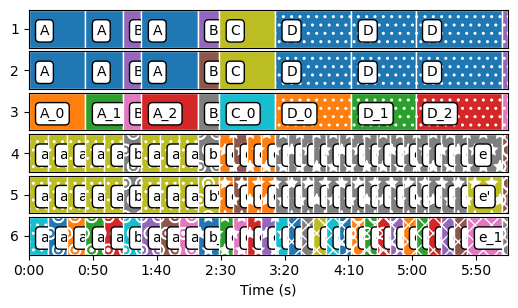

In [28]:
hr.plot()

In [27]:
print(salami_annos[1].T, salami_adobe.T)
hr, he = bnl.mtr.align_hier(salami_annos[0], salami_adobe)
hr = hr.expand()
bnl.mtr.lmeasure(hr, he)

374.6548 374.622


(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)

In [38]:
# Let's get rid of levels and see what happenes


for new_levels in [list(range(x)) for x in range(1, 13)]:
    new_he = bnl.levels2H([he.levels[l] for l in new_levels])
    print(new_levels)
    print(bnl.mtr.lmeasure(hr, new_he))

[0]
(0.34266027780591196, 0.00012623571890510581, 0.0002523784618260422)
[0, 1]
(0.6581936658011615, 0.6795731463818321, 0.6687125683245045)
[0, 1, 2]
(0.6926545525963147, 0.8361129926114956, 0.757652754511553)
[0, 1, 2, 3]
(0.6956489005800305, 0.8792069026274381, 0.77673056028302)
[0, 1, 2, 3, 4]
(0.7054514469663883, 0.9395109533962077, 0.8058291926527081)
[0, 1, 2, 3, 4, 5]
(0.7056384890536834, 0.9415027442302306, 0.8066831920101684)
[0, 1, 2, 3, 4, 5, 6]
(0.6956571429995844, 0.9480288015586521, 0.8024683909441865)
[0, 1, 2, 3, 4, 5, 6, 7]
(0.6850420359263201, 0.9501075221191366, 0.7960905937918014)
[0, 1, 2, 3, 4, 5, 6, 7, 8]
(0.6850744418311399, 0.9508836085628813, 0.7963847938835593)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(0.6853581535152334, 0.9529612492576849, 0.7973045561901873)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(0.6846689158186323, 0.9513795015694538, 0.7962844680495973)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)


In [34]:
for x in range(1, len(he.levels) + 1):
    new_levels = list(range(len(he.levels) - x, len(he.levels)))
    # new_levels.reverse()
    new_he = bnl.levels2H([he.levels[l] for l in new_levels])
    print(new_levels)
    print(bnl.mtr.lmeasure(hr, new_he))

[11]
(0.9027779385764622, 0.6228473124352261, 0.7371309728851035)
[10, 11]
(0.8973244392359175, 0.6643869165574928, 0.7634837450903399)
[9, 10, 11]
(0.9000255480312855, 0.6764759985517441, 0.7724009946532311)
[8, 9, 10, 11]
(0.9015321610560229, 0.6851291347050184, 0.7785731599595048)
[7, 8, 9, 10, 11]
(0.8956583777505992, 0.6863716687835092, 0.7771717569377471)
[6, 7, 8, 9, 10, 11]
(0.8989093119210908, 0.7335540979020062, 0.8078571384009704)
[5, 6, 7, 8, 9, 10, 11]
(0.9085913915774447, 0.8676583149135777, 0.8876532087579576)
[4, 5, 6, 7, 8, 9, 10, 11]
(0.9088797688137802, 0.8709141231418888, 0.889492014188317)
[3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.8173827484454703, 0.8814992183617402, 0.8482310930772485)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.8162596175563637, 0.9537984857846489, 0.8796854586444323)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6829752857248348, 0.9538795555721674, 0.796009695640166)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)


(<Figure size 500x290 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

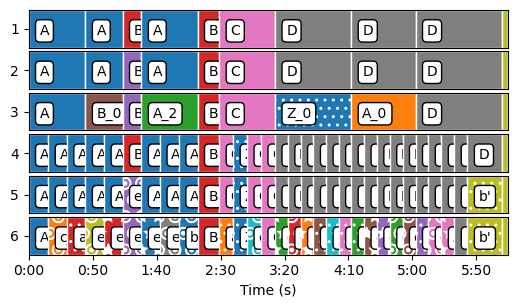

In [36]:
hr.relabel().plot()

In [20]:
bnl.mtr.lmeasure(hr, new_he)

(0.8586787690885265, 0.627727157434456, 0.7252608096499328)

In [13]:
from bnl import metrics, fio
bad_id='1010'
salami_annos = fio.salami_ref_hiers(tid=bad_id)
salami_adobe = fio.adobe_hiers(tid=bad_id)


In [14]:
ref= salami_annos[1]
est= salami_annos[0]
print(metrics.time_lmeasure(ref, est, frame_size=0))
print(metrics.time_lmeasure(ref, est, frame_size=0.5))
print(metrics.time_lmeasure(ref, est, frame_size=0.2))
print(metrics.time_lmeasure(ref, est, frame_size=0.1))

(0.15095305442810059, (0.7366836355959089, 0.736543345875254, 0.7366134840559572))
(0.2579917907714844, (0.7600089438142289, 0.8376851003977025, 0.7969588053590114))
(0.7335591316223145, (0.7558285058507821, 0.834840011231004, 0.7933719332935493))
(1.8798332214355469, (0.7541893548256449, 0.832430667153229, 0.7913808462020459))


In [ ]:
salami_annos[1].labels, salami_annos[0].itvls

In [ ]:
hierarchy.lmeasure(salami_annos[1].itvls, salami_annos[1].labels, salami_annos[0].itvls, salami_annos[0].labels)

In [ ]:
import mir_eval
from mir_eval import hierarchy
hierarchy.lmeasure(salami_annos[1].itvls, salami_annos[1].labels, salami_adobe.itvls, salami_adobe.labels, frame_size=0.1)

In [ ]:
salami_adobe.plot()

In [ ]:
salami_annos[0].T

## Let's investigate!

- Transitivity, and effects of depth.
- Window and its effects. (It's faster now so we probably don't need it. Let's check the original claim that over all frames are redundant)
    - We can visualize this by looking at how window size affect the per time measures iota alpha and rho.
- Monotonicity Meet and its effect.
    - Again look at per time measures and how they change before and after.



In [ ]:
tids = bnl.fio.salami_tids()
hiers = bnl.fio.salami_ref_hiers(tid=tids[0])
hiers

In [ ]:
hiers[0].plot(text=False)